# Urbansed

In [1]:
# Automatically reload modules before entering the execution of code typed at 
# the IPython prompt
%load_ext autoreload
%autoreload 2

In [2]:
# Import used libraries
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import librosa
import torch

torch.manual_seed(0)

print(f"{pd.__name__} version: {pd.__version__}")
print(f"{matplotlib.__name__} version: {matplotlib.__version__}")
print(f"{librosa.__name__} version: {librosa.__version__}")
print(f"{torch.__name__} version: {torch.__version__}")

pandas version: 2.1.2
matplotlib version: 3.8.3
librosa version: 0.10.2.post1
torch version: 2.4.0


In [3]:
from yoho.utils import AudioFile

def plot_melspectrogram(
    audio: AudioFile,
    n_mels: int = 40,
    win_len: float = 0.04,
    hop_len: float = 0.01,
):
    """
    Plots the Mel spectrogram.
    """
    plt.figure(figsize=(10, 4))
    plt.title(f"Mel spectrogram")
    librosa.display.specshow(
        data=audio.mel_spectrogram(
            n_mels=n_mels, win_len=win_len, hop_len=hop_len
        ),
        sr=audio.sr,
        hop_length=hop_len*audio.sr,
        x_axis="s",
        y_axis="mel",
    )
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

## Dataset

In [4]:
from yoho.train import load_dataset
from yoho.utils import UrbanSEDDataset

urbansed_train = load_dataset(partition="train")
urbansed_val = load_dataset(partition="validate")

print(f"Number of audio clips in the train dataset: {len(urbansed_train)}")
print(f"Number of audio clips in the validation dataset: {len(urbansed_val)}")
print(f"Duration of each audio clips: {urbansed_train.audios[0].duration} seconds")
print(f"Sampling rate of each audio clips: {urbansed_train.audios[0].sr} Hz")

INFO:root:Loading the train dataset from the pickle file
INFO:root:Loading the validation dataset from the pickle file


Number of audio clips in the train dataset: 54000
Number of audio clips in the validation dataset: 18000
Duration of each audio clips: 2.56 seconds
Sampling rate of each audio clips: 44100 Hz


## Data generator

In [5]:
from yoho.utils import YOHODataGenerator

val_dataloader = YOHODataGenerator(
    urbansed_val, batch_size=32, shuffle=True
)

val_features, val_labels = next(iter(val_dataloader))

print(f"Test features shape: {val_features.shape}")
print(f"Test labels shape: {val_labels.shape}")

Test features shape: torch.Size([32, 1, 40, 257])
Test labels shape: torch.Size([32, 33, 9])


## YOHO model

In [6]:
from torchsummary import summary

from yoho.models import YOHO
from yoho.train import get_device

# Get the available device (cuda, mps or cpu)
device = get_device()

# Define the model
urbansed_model = YOHO(
    name="UrbanSEDYOHO",
    input_shape=(1, 40, 257), n_classes=len(urbansed_train.labels)
).to(device)

urbansed_model.load(f"./models/{urbansed_model.name}_checkpoint.pth.tar", device)

summary(
    urbansed_model,
    input_size=(1, 40, 257),
    batch_size=32,
)

RuntimeError: Error(s) in loading state_dict for YOHO:
	size mismatch for final_conv1d.weight: copying a param with shape torch.Size([30, 256, 1]) from checkpoint, the shape in current model is torch.Size([33, 256, 1]).
	size mismatch for final_conv1d.bias: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([33]).

## Evaluation
### Train and validation losses

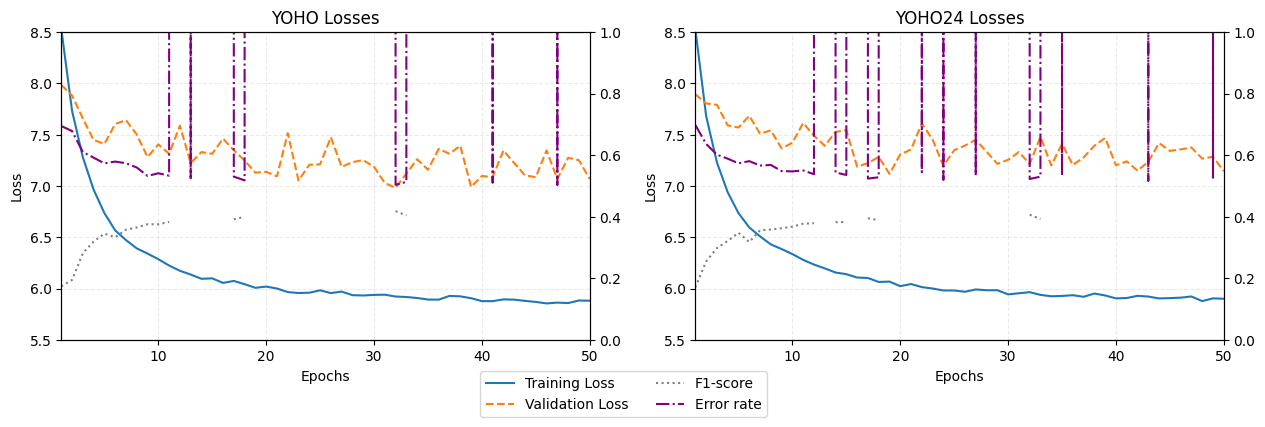

In [26]:
import json
import matplotlib.pyplot as plt

# Path to the losses.json file:

# Load the losses.json file
with open("./models/UrbanSEDYOHO_losses.json", "r") as f:
    losses = json.load(f)

# Extract epochs, train_loss, and val_loss
epochs = []
train_losses = []
val_losses = []
f1_scores = []
error_rates = []

for epoch, metrics in losses.items():
    epochs.append(int(epoch))
    train_losses.append(metrics["train_loss"])
    val_losses.append(metrics["val_loss"])
    f1_scores.append(metrics["f1_score"])
    error_rates.append(metrics["error_rate"])

# Sort the data by epochs to ensure correct plotting
epochs, train_losses, val_losses = zip(
    *sorted(zip(epochs, train_losses, val_losses))
)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].set_title("YOHO Losses")
ax[0].plot(epochs, train_losses, label="Training Loss")
ax[0].plot(epochs, val_losses, label="Validation Loss", linestyle="--")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_xlim(1, epochs[-1]) # Set the x-axis limits to the number of epochs
ax[0].set_ylim(5.5,8.5)
ax[0].grid(alpha=.25, linestyle='--')

ax_1 = ax[0].twinx()
ax_1.plot(epochs, f1_scores, label="F1-score", linestyle=":", color='grey')
ax_1.plot(epochs, error_rates, label="Error rate", linestyle="-.", color='purple')

ax_1.set_ylim(0, 1)

with open("./models/UrbanSEDYOHO24_losses.json", "r") as f:
    losses = json.load(f)

# Extract epochs, train_loss, and val_loss
epochs = []
train_losses = []
val_losses = []
f1_scores = []
error_rates = []

for epoch, metrics in losses.items():
    epochs.append(int(epoch))
    train_losses.append(metrics["train_loss"])
    val_losses.append(metrics["val_loss"])
    f1_scores.append(metrics["f1_score"])
    error_rates.append(metrics["error_rate"])

# Sort the data by epochs to ensure correct plotting
epochs, train_losses, val_losses = zip(
    *sorted(zip(epochs, train_losses, val_losses))
)

ax[1].set_title("YOHO24 Losses")
ax[1].plot(epochs, train_losses, label="Training Loss")
ax[1].plot(epochs, val_losses, label="Validation Loss", linestyle="--")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_xlim(1,50)
ax[1].set_ylim(5.5,8.5)
ax[1].grid(alpha=.25, linestyle='--')

ax_1 = ax[1].twinx()
ax_1.plot(epochs, f1_scores, label="F1-score", linestyle=":", color='grey')
ax_1.plot(epochs, error_rates, label="Error rate", linestyle="-.", color='purple')

ax_1.set_ylim(0, 1)

# Get ax[0] and ax[0].twinx() legend handles and labels
handles0, labels0 = ax[1].get_legend_handles_labels()
handles1, labels1 = ax_1.get_legend_handles_labels()
fig.legend(handles0 + handles1, labels0 + labels1, loc='lower center', ncol=2, bbox_to_anchor=(0.5,-0.1))

plt.show()

In [ ]:
plot_melspectrogram(urbansed_val.audios[41])

In [16]:
predictions = urbansed_model(val_features.to(device))
targets = val_labels.to(device)

In [25]:
import numpy as np


def process_output(
    output: np.array, classes: list[str]
) -> list[tuple[str, float, float]]:

    STEPS_NO = 9
    step_duration = 2.56 / STEPS_NO
    MIN_EVENT_DURATION = 0
    MIN_SILENCE_DURATION = 1.0

    processed_output = []

    for k in range(output.shape[0]):

        labels = []
        for i in range(output.shape[2]):

            for j in range(0, output.shape[1], 3):
                if output[k, j, i] >= 0.5:
                    label = classes[j // 3]
                    start = (
                        i * step_duration
                        + output[k, j + 1, i].item() * step_duration
                    )
                    end = (
                        i * step_duration
                        + output[k, j + 2, i].item() * step_duration
                    )
                    labels.append((label, round(start, 2), round(end, 2)))

        # Order the labels by class
        labels = sorted(labels, key=lambda x: x[0])

        # Merge events of the same class that are close to each other
        merged_labels = []
        for label, start, end in labels:
            if not merged_labels:
                merged_labels.append((label, start, end))
            else:
                prev_label, prev_start, prev_end = merged_labels[-1]
                if (
                    prev_label == label
                    and start - prev_end < MIN_SILENCE_DURATION
                ):
                    merged_labels[-1] = (label, prev_start, end)
                else:
                    merged_labels.append((label, start, end))

        # Remove events that are too short
        merged_labels = [
            (label, start, end)
            for label, start, end in merged_labels
            if end - start >= MIN_EVENT_DURATION
        ]

        # Order the labels by start time
        # If two events start at the same time, order by class index
        merged_labels = sorted(
            merged_labels, key=lambda x: (x[1], classes.index(x[0]))
        )

        processed_output.append(merged_labels)

    return processed_output

print(
    process_output(targets, urbansed_train.labels), 
    process_output(predictions, urbansed_train.labels), sep="\n"
)

In [28]:
def get_test_set():
    urbansed_test = UrbanSEDDataset(
        audios=[
            audioclip
            for _, audio in enumerate(
                AudioFile(filepath=file.filepath, labels=eval(file.events))
                for _, file in pd.read_csv(
                    "./data/raw/UrbanSED/test.csv"
                ).iterrows()
            )
            for audioclip in audio.subdivide(win_len=2.56, hop_len=1.00)
        ]
    )
    return urbansed_test


urbansed_test = get_test_set()

In [66]:
urbansed_test_dataloader = YOHODataGenerator(
    urbansed_test, batch_size=4, shuffle=False
)

In [94]:
import sed_eval
import dcase_util

def compute_metrics(predictions, targets, classes, filepaths):
    """
    Computes the error rate and F1 score for the given predictions and targets.
    """

    # Process the outputs
    processed_predictions = process_output(predictions.cpu().numpy(), classes)
    processed_targets = process_output(targets.cpu().numpy(), classes)

    # Initialize the metrics
    total_error_rate = 0.0
    total_f1_score = 0.0

    # Compute the metrics for each prediction
    for pred, target, filepath in zip(
        processed_predictions, processed_targets, filepaths
    ):
        
        print(f"Processing {filepath}...")
        print(f"Prediction: {pred}")
        print(f"Target: {target}")

        # Create the event list
        pred_event_list = dcase_util.containers.MetaDataContainer(
            [
                {
                    "file": filepath,
                    "event_label": event[0],
                    "onset": event[1],
                    "offset": event[2],
                }
                for event in pred
            ]
        )

        # Create the target event list
        target_event_list = dcase_util.containers.MetaDataContainer(
            [
                {
                    "file": filepath,
                    "event_label": event[0],
                    "onset": event[1],
                    "offset": event[2],
                }
                for event in target
            ]
        )

        segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
            event_label_list=classes,
            time_resolution=1.0,
        )

        # Evaluate
        N_ref = len(target_event_list)
        if len(pred_event_list) > 0 and N_ref > 0:  # Ensure there are predictions and references
            segment_based_metrics.evaluate(
                reference_event_list=target_event_list,
                estimated_event_list=pred_event_list,
            )

            overall_metrics = segment_based_metrics.results_overall_metrics()

            # Compute the error rate and f1 score
            total_error_rate += overall_metrics["error_rate"]["error_rate"]
            total_f1_score += overall_metrics["f_measure"]["f_measure"]

            print(f"Error rate: {overall_metrics['error_rate']['error_rate']}")
            print(f"F1 score: {overall_metrics['f_measure']['f_measure']}")

        else:
            # If there are no predictions or no ground truth, handle accordingly
            if N_ref == 0:
                # No reference events means no error, and F1 remains unchanged
                total_error_rate += 0
            else:
                # No predictions but reference events: set error rate to 1, F1 score to 0
                total_error_rate += 1 
                total_f1_score += 0.0  # No predictions, F1 should be zero


    # Compute the average error rate and F1 score
    total_error_rate /= len(processed_predictions)
    total_f1_score /= len(processed_predictions)

    return total_error_rate, total_f1_score

In [97]:
error_rate = 0.0
f1_score = 0.0
num_batches = 0

with torch.no_grad():
    for _, (inputs, labels) in enumerate(urbansed_test_dataloader):
        # Move the inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)
        # Compute the outputs
        outputs = urbansed_model(inputs)

        filepaths = [
            audio.filepath
            for audio in urbansed_test_dataloader.dataset.audios[
                _ * urbansed_test_dataloader.batch_size : (_ + 1) * urbansed_test_dataloader.batch_size
            ]
        ]

        # Compute the error rate and f1 score
        running_error_rate, running_f1_score = compute_metrics(
            predictions=outputs,
            targets=labels,
            classes=urbansed_train.labels,
            filepaths=filepaths,
        )

        error_rate += running_error_rate
        f1_score += running_f1_score
        num_batches += 1

# Now, instead of dividing by the length of the dataloader, divide by the actual number of batches processed
error_rate /= num_batches
f1_score /= num_batches

print(f"Total Error rate: {error_rate:.2f}")
print(f"Total F1 score: {f1_score:.2f}")


In [ ]:
import sed_eval
import dcase_util

labels_ = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

all_thruth_data = dcase_util.containers.MetaDataContainer()
all_predictions = dcase_util.containers.MetaDataContainer()


for idx, (features, _) in enumerate(urbansed_test_dataloader):

    # Get model predictions
    prediction = urbansed_model(features.to(device))
    labels = process_output(prediction[0])

    thruth = urbansed_test.audios[idx].labels
    print(f"Truth for audio clip {idx}: {thruth}")
    print(f"Prediction for audio clip {idx}: {labels}")

    all_thruth_data += dcase_util.containers.MetaDataContainer(
        [
            {
                "filename": f"{idx}.wav",
                "onset": onset,
                "offset": offset,
                "event_label": label,
            }
            for label, onset, offset in labels
        ]
    )

    all_predictions = dcase_util.containers.MetaDataContainer(
        [
            {
                "filename": f"{idx}.wav",
                "onset": onset,
                "offset": offset,
                "event_label": label,
            }
            for label, onset, offset in thruth
        ]
    )

    break


segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
    event_label_list=labels_,
    time_resolution=1.0,
)

# Evaluate the predictions
segment_based_metrics.evaluate(all_predictions, all_thruth_data)

overall_segment_based_metrics = segment_based_metrics.results_overall_metrics()
curr_f1 = overall_segment_based_metrics['f_measure']['f_measure']
curr_error = overall_segment_based_metrics['error_rate']['error_rate']

print("F1: {:.3f}, Error: {:.3f}".format(curr_f1, curr_error))